# 감성 분류

- 분류 모델의 가장 대표적인 활용 방법 중 하나
- 텍스트 데이터를 긍정 또는 부정으로 나누어 분류하는 것


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from selenium import webdriver
from bs4 import BeautifulSoup
import re
import time
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import requests
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from konlpy.tag import Okt

# 맛집 상세페이지 url 정보 크롤링

In [40]:
# 크롤링할 주소
url = "https://map.kakao.com/"

In [41]:
driver = webdriver.Chrome()

# 카카오지도 접속
driver.get(url)

# 검색창에 검색어 입력
searchbox = driver.find_element(By.CSS_SELECTOR, "input.query")
searchbox.send_keys("신촌맛집")

# 엔터 눌러서 결과 받아오기
searchbox.send_keys(Keys.ENTER)

# 검색 결과를 가져올 시간 대기
time.sleep(1)

# html 정보 파싱
soup = BeautifulSoup(driver.page_source, "lxml")
moreviews = soup.select("a.moreview")


# 크롤링할 페이지 리스트 생성
page_urls = []
for more in moreviews:
    page = more.get("href")
    page_urls.append(page)

driver.close()

# 상세페이지에서 리뷰 크롤링

In [16]:
res = requests.get("https://place.map.kakao.com/commentlist/v/8375653/")
data = res.json()

In [17]:
# 별점
data["comment"]["list"][0]["point"]

1

In [24]:
# 댓글
data["comment"]["list"][0]["contents"]

'박한 평점에 걱정했지만, 꽤 괜찮았던 샤브샤브집.\n더 좋은 서비스를 제공하고 싶다면, 음식 회전율을 더 높여야.'

In [19]:
data["comment"]["list"][-1]["commentid"]

'9018118'

In [42]:
stars = []
reviews = []

# 댓글정보 url
base_url = "https://place.map.kakao.com/commentlist/v/"

# 위에서 수집한 15개에 대해서 수집
for url in page_urls:
    last_id = ""

    # 5번 더보기 수행
    for _ in range(5):
        res = requests.get(base_url + url[28:] + "/" + last_id)
        data = res.json()

        for review in data["comment"]["list"]:
            stars.append(review["point"])
            reviews.append(review.get("contents", ""))

        last_id = review["commentid"]
        time.sleep(1)

In [43]:
len(reviews)

375

In [44]:
df = pd.DataFrame({"score": stars, "reivew": reviews})

In [45]:
df.head()

,score,reivew
0,5,청결한 매장에 들어서는 순간 찐맛집 스멜~ 진하게 느낄 수 있는 곳!!!\n떡볶이 ...
1,5,"맛, 가성비, 친절한 서비스 무엇 하나 빠지지 않네요🥹 번창하세요!!"
2,5,
3,5,5점을 안줄수가 없는집\n집근처에있어서 너무 감사한곳\n
4,5,사장님 친절하시고 맛있어요. 떡볶이 조금만 덜 짜면 베스트예요^^


In [46]:
df["score"].value_counts()

score
5    161
1     75
4     73
3     39
2     27
Name: count, dtype: int64

In [47]:
# 4점 이상 리뷰는 긍정 리뷰, 3점 이하는 부정 리뷰로 평가
df["y"] = df["score"].map(lambda x: 1 if x > 3 else 0)

In [48]:
df.head()

,score,reivew,y
0,5,청결한 매장에 들어서는 순간 찐맛집 스멜~ 진하게 느낄 수 있는 곳!!!\n떡볶이 ...,1
1,5,"맛, 가성비, 친절한 서비스 무엇 하나 빠지지 않네요🥹 번창하세요!!",1
2,5,,1
3,5,5점을 안줄수가 없는집\n집근처에있어서 너무 감사한곳\n,1
4,5,사장님 친절하시고 맛있어요. 떡볶이 조금만 덜 짜면 베스트예요^^,1


In [49]:
# 레이블값 비율 확인
df["y"].value_counts()

y
1    234
0    141
Name: count, dtype: int64

# 텍스트 전처리

## 한글 추출

In [54]:
def text_cleaning(text: str) -> str:
    """
    텍스트 정제함수
    한글 이외의 문자는 전부 제거
    """

    # 한글 이외의 문자들 추출
    han = re.compile("[^ ㄱ-ㅣ가-힣]+")
    # 한글 이외의 문자들 제거
    text = han.sub(" ", text).strip()

    return text

In [55]:
text_cleaning("테스트용 텍스트 정제 잘하고있나?? abc 1234")

'테스트용 텍스트 정제 잘하고있나'

In [56]:
df["ko_text"] = df["reivew"].map(text_cleaning)

In [57]:
df.head()

,score,reivew,y,ko_text
0,5,청결한 매장에 들어서는 순간 찐맛집 스멜~ 진하게 느낄 수 있는 곳!!!\n떡볶이 ...,1,청결한 매장에 들어서는 순간 찐맛집 스멜 진하게 느낄 수 있는 곳 떡볶이 너무너무...
1,5,"맛, 가성비, 친절한 서비스 무엇 하나 빠지지 않네요🥹 번창하세요!!",1,맛 가성비 친절한 서비스 무엇 하나 빠지지 않네요 번창하세요
2,5,,1,
3,5,5점을 안줄수가 없는집\n집근처에있어서 너무 감사한곳\n,1,점을 안줄수가 없는집 집근처에있어서 너무 감사한곳
4,5,사장님 친절하시고 맛있어요. 떡볶이 조금만 덜 짜면 베스트예요^^,1,사장님 친절하시고 맛있어요 떡볶이 조금만 덜 짜면 베스트예요


In [58]:
df.shape

(375, 4)

In [59]:
# 내용이 없는 데이터 제거
df = df[df["ko_text"].str.len() > 0]

In [61]:
df.shape

(287, 4)

### 형태소 추출

In [64]:
def get_pos(x) -> list:
    """
    텍스트 데이터에서 형태소 추출하는 함수
    """
    okt = Okt()
    pos = okt.pos(x)
    pos = [f"{word}/{tag}" for word, tag in pos]

    return pos

In [65]:
# 테스트1
okt = Okt()
okt.pos("집에 가고 싶다")

[('집', 'Noun'), ('에', 'Josa'), ('가고', 'Verb'), ('싶다', 'Verb')]

In [68]:
# 테스트2
result = get_pos(df["ko_text"].values[0])
result

['청결한/Adjective',
 '매장/Noun',
 '에/Josa',
 '들어서는/Verb',
 '순간/Noun',
 '찐/Verb',
 '맛집/Noun',
 '스멜/Noun',
 '진하게/Adjective',
 '느낄/Verb',
 '수/Noun',
 '있는/Adjective',
 '곳/Noun',
 '떡볶이/Noun',
 '너무/Adverb',
 '너무/Adverb',
 '맛있고/Adjective',
 '양도/Noun',
 '푸/Verb',
 '짐해/Noun',
 '요/Josa',
 '튀김/Noun',
 '은/Josa',
 '또/Noun',
 '얼마나/Noun',
 '군침/Noun',
 '돌게/Verb',
 '정갈히/Adjective',
 '나오는지/Verb',
 '옆/Noun',
 '테이블/Noun',
 '돈까스/Noun',
 '맛/Noun',
 '나게/Verb',
 '보이는데/Verb',
 '갈/Verb',
 '때/Noun',
 '마다/Josa',
 '떡볶이/Noun',
 '에/Josa',
 '미쳐/Adjective',
 '아직/Adverb',
 '돈까스/Noun',
 '를/Josa',
 '못/Noun',
 '먹었네요/Verb',
 '언제/Noun',
 '간/Suffix',
 '먹어야/Verb',
 '징/Noun',
 'ㅎㅎ/KoreanParticle',
 '사장/Noun',
 '님/Suffix',
 '여기/Noun',
 '신촌/Noun',
 '맛집/Noun',
 '찐/Verb',
 '팬/Noun',
 '한/Determiner',
 '명/Noun',
 '추가/Noun',
 '입니당/Adjective']

## 텍스트 임베딩

- 텍스트 데이터를 연산이 가능하도록 피치

### TF-IDF(Team Frequency-Inverse Document Frequency)

- 단어의 빈도와 역문서 빈도를 사용하여 각 단어들의 중요도를 가중치로 주는 방법
- TF : 1개의 문서 내에서 특정 단어의 등장 빈도
- DF : 특정 단어가 등장한 문서 수
- IDF : DF에 반비례하는 수
- 다른 문서들에서는 많이 등장하지 ㅇ낳았지만 현재 문서에서는 많이 등장하는 단어를 의미
    - 해당 단어가 현재 문서에서 얼마나 중요한지를 계산하는 방법

In [74]:
x = df["ko_text"]
y = df["y"]
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=11
)

In [75]:
len(x_train)

200

In [76]:
tfidf = TfidfVectorizer()
tf_train = tfidf.fit_transform(x_train)
tf_test = tfidf.transform(x_test)

In [77]:
tf_train.shape

(200, 2061)

In [78]:
type(tf_train)

scipy.sparse._csr.csr_matrix

In [79]:
pd.DataFrame(tf_train)

,0
0,"(0, 1085)\t0.6697245816248998\n (0, 1843)\t..."
1,"(0, 1564)\t0.21247707069109623\n (0, 711)\t..."
2,"(0, 1248)\t0.10911814388714346\n (0, 213)\t..."
3,"(0, 641)\t0.39278925270847\n (0, 1209)\t0.3..."
4,"(0, 1550)\t0.35933621412796435\n (0, 547)\t..."
...,...
195,"(0, 1254)\t0.37702217366652996\n (0, 764)\t..."
196,"(0, 506)\t0.13343922719024104\n (0, 1040)\t..."
197,"(0, 2037)\t0.3313032892004907\n (0, 1721)\t..."
198,"(0, 1792)\t0.4130723439276447\n (0, 509)\t0..."


## 모델 훈련

In [ ]:
logi = LogisticRegression()
logi.fit(tf_train, y_train)

LogisticRegression()

In [83]:
pred = logi.predict(tf_test)
proba = logi.predict_proba(tf_test)[:, 1]

In [84]:
print(accuracy_score(y_test, pred))
print(f1_score(y_test, pred))

0.5632183908045977
0.7205882352941176


In [85]:
comat = confusion_matrix(y_test, pred)
print(comat)

[[ 0 38]
 [ 0 49]]


In [86]:
pd.DataFrame({"text": x_test, "pred": pred})

,text,pred
181,가격대는 좀 있지만 맛있고 정갈하고 친절했습니다 좌식이라 아기를 데리고 가기 좋더군요,1
302,버거가 내용물을 너무 대충 넣네요 다른지점대비 별로예요,1
297,맛 가성비 서비스 음식 나오는 속도 맛있어요 근데 가격이 아주 조금 비...,1
191,고딩 때 멋모르고 들어갔다가 아빠 등골 도 돼서 나옴 맛은 기억안남 맛있었겠지 뭐,1
252,순대국밥 인 그 가격에 비해 건더기 너무 부실해요 맛도 그냥 별로인 순대국밥...,1
...,...,...
202,가성비가 좋은지는 모르겠어요 ㅎㅎ 건물이 노후됐다고 느껴졌어요 그러나 음식은 맛있...,1
43,별로에요,1
230,밀크티 존맛,1
84,맛은 있음 근데 불친절함 많이 불친절함 청결한것도 아니고 친절한것도 아니고 굳이...,1


# 모델 최적화

In [90]:
# 1 : 1 비율로 랜덤샘플링 수행
df["y"].value_counts()

y
1    172
0    115
Name: count, dtype: int64

In [92]:
pos_idx = df[df["y"] == 1].sample(115, random_state=11).index.tolist()
neg_idx = df[df["y"] == 0].index.tolist()

In [97]:
random_idx = pos_idx + neg_idx
sample_x = df["ko_text"][random_idx]
sample_y = df["y"][random_idx]

In [98]:
len(sample_x), len(sample_y)

(230, 230)

In [99]:
x_train, x_test, y_train, y_test = train_test_split(
    sample_x, sample_y, test_size=0.3, stratify=sample_y, random_state=11
)

In [101]:
tfidf = TfidfVectorizer()
tf_train = tfidf.fit_transform(x_train)
tf_test = tfidf.transform(x_test)

In [102]:
logi = LogisticRegression()
logi.fit(tf_train, y_train)

LogisticRegression()

In [109]:
pred = logi.predict(tf_test)
proba = logi.predict_proba(tf_test)[:,1]

In [110]:
print(accuracy_score(y_test, pred))
print(f1_score(y_test, pred))

0.7391304347826086
0.7272727272727272


In [111]:
comat = confusion_matrix(y_test,pred)
print(comat)

[[27  7]
 [11 24]]


In [112]:
pd.DataFrame({"text": x_test, "pred":pred})

,text,pred
163,괜찮은 식사였습니다,0
55,전반적인 음식 맛은 괜찮았지만 위생에서 확 깼네요 집게 안쪽이 깔끔한건 찾기가 힘들...,0
131,학생때부터 다니던 곳 우동 고치돈 이렇게 드세요,1
119,혼밥 하러 가는 사람에게 매우 불친절합니다 자기들 편하자고 좁아 터진 자리로 사...,1
271,별로,0
...,...,...
57,가족과 함께 맛있게 잘 먹었습니다 번창 하세요,1
365,친절하고 분위기도 좋고 매장도 깔끔하고 좋습니다 물론 맛은 기본입니다,1
237,아늑한 분위기가 좋아요 음료는 쏘쏘하지만 다른 클로리스 지점들보다 편안한 분위기라...,1
224,등심스테이크 원 사이었던거 같음 근데 그에 준하는 맛은 아닌듯 소스는 애매하고...,0


In [126]:
# 테스트
query = tfidf.transform(["맛있었다"])
logi.predict(query)

array([0], dtype=int64)

# 키워드 분석

- 로지스틱 회귀 모델의 피처 영향력으로 가장 높은 영향력을 가지고 있는 단어 찾기

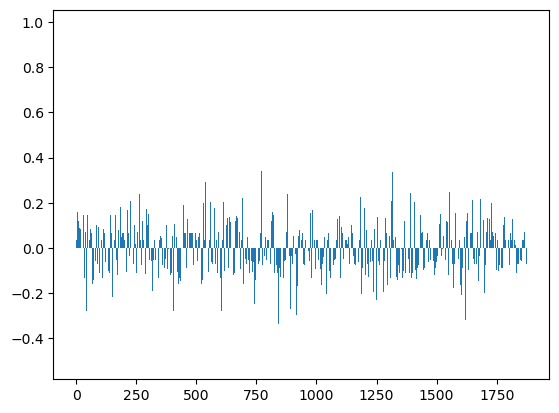

In [127]:
plt.figure()

plt.bar(range(len(logi.coef_.flatten())), logi.coef_.flatten())
plt.show()

In [134]:
# 회귀 모델의 계수를 내림차순으로 정렬
coef_pos_idx = sorted(((value ,idx) for idx, value in enumerate(logi.coef_.flatten())), reverse=True)
coef_pos_idx

[(0.9804616234089784, 1535),
 (0.5770878114093129, 639),
 (0.563748526723513, 647),
 (0.45608979745278033, 631),
 (0.4089643207822737, 1856),
 (0.4089643207822737, 1750),
 (0.40852871283925646, 643),
 (0.39308540114542645, 1588),
 (0.363616720659458, 133),
 (0.3421639898055933, 771),
 (0.3369736801261904, 1316),
 (0.3181530239200698, 1035),
 (0.3071133480619311, 1507),
 (0.30358499315421006, 1691),
 (0.29562915645091337, 1289),
 (0.293617626022196, 538),
 (0.2920223986135374, 1829),
 (0.2919160143357977, 773),
 (0.2891814444884962, 1789),
 (0.2891814444884962, 1518),
 (0.2891814444884962, 864),
 (0.2891814444884962, 449),
 (0.2891814444884962, 295),
 (0.2891814444884962, 11),
 (0.28906832909749947, 1544),
 (0.2890054139643576, 1821),
 (0.28758130484889194, 74),
 (0.2863830070988883, 1743),
 (0.27771200572524923, 698),
 (0.2672575448160496, 1548),
 (0.26616007059915286, 636),
 (0.26463882349624224, 1709),
 (0.26463882349624224, 1494),
 (0.2645970546207929, 1791),
 (0.2622127536438158, 1

In [141]:
# 상위 20개 긍정 형태소
for value, idx in coef_pos_idx[:20]:
    print(tfidf.get_feature_names_out()[idx], value)

좋아요 0.9804616234089784
맛있어요 0.5770878114093129
맛집 0.563748526723513
맛있고 0.45608979745278033
혼밥 0.4089643207822737
터줏대감 0.4089643207822737
맛있었어요 0.40852871283925646
줄서서 0.39308540114542645
고기는 0.363616720659458
밀크티 0.3421639898055933
우동 0.3369736801261904
시끄러움 0.3181530239200698
정신없긴한데 0.3071133480619311
추억의 0.30358499315421006
오지마세요 0.29562915645091337
떡볶이 0.293617626022196
한번 0.2920223986135374
밀크티도 0.2919160143357977
평양냉면 0.2891814444884962
조만간 0.2891814444884962


In [142]:
# 상위 20개 부정 형태소
for value, idx in coef_pos_idx[:-20:-1]:
    print(tfidf.get_feature_names_out()[idx],value)

쏘쏘 -0.5074190601742476
별로에요 -0.489249350220511
그닥 -0.3932065176572541
보통 -0.3636749273363455
직원이 -0.3483242515205808
다신 -0.34617720462040347
별로네요 -0.3368127100865979
아니고 -0.33085609925265674
하나도 -0.32766114869746815
조금 -0.3276177804238268
진짜 -0.3171748368757483
비추 -0.29830205213396754
비해 -0.29256496708404184
아까움 -0.2823074937413161
없고 -0.28119551513893587
가성비꽝 -0.27803899504219226
괜찮은집 -0.27803899504219226
다시는안간다 -0.27803899504219226
말그대로 -0.27803899504219226
